# Classification of CIFAR10 Data in Pytorch

In [3]:
import torch 
import numpy as np
from matplotlib import pyplot as plt

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA not available: Turning on CPU...")
else:
    print("CUDA is available: Turning on GPU...")

CUDA not available: Turning on CPU...


## Loading Data

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 0
valid_size = 0.2
batch_size = 20

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),
                         (0.5,0.5,0.5))
])
train_data = datasets.CIFAR10('data', train=True, 
                              transform=transform, download=True)
test_data = datasets.CIFAR10('data', train=False, 
                             transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
num_train = len(train_data)
indices = list(np.arange(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)



In [6]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

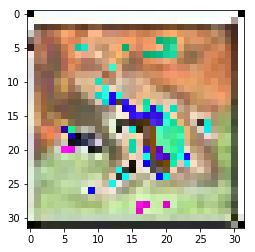

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
show(images[2])

### CNN Archtecture 

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2d(input_depth, output_depth, conv_kernel_size )
        self.conv1 = nn.Conv2d(3,16,3, padding=1)
        self.conv2 = nn.Conv2d(16,32,3, padding=1)
        self.conv3 = nn.Conv2d(32,64,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*4*4,500)
        self.fc2 = nn.Linear(500,10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
    def forward(self,x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1,64*4*4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return x
model = Net()
print(model)

# on gpu 
if train_on_gpu:
    model.cuda()
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
        
        

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
)


In [9]:
# training

In [10]:
from tqdm import tqdm
epochs = 5
train_loss = []
valid_loss = []
valid_loss_min = np.inf
# training
for e in range(epochs):
    model.train()
    epoch_loss = 0
    model.train()
    for ii,(images, labels) in tqdm(enumerate(train_loader)):
        if train_on_gpu:
            images,labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        epoch_loss +=loss
        # if on cpu: train for only 100 batches per epoch:
        # for test only
        if not train_on_gpu:
            if ii>=100:
                break
    train_loss.append(epoch_loss/ii)
    ### validation ###
    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for ii,(images, labels) in enumerate(validation_loader):
            if train_on_gpu:
                images, labels = iamges.cuda(), labels.cuda()
            output = model.forward(images)
            loss = criterion(output,labels)
            epoch_loss +=loss
            if not train_on_gpu:
                if ii>=100:
                    break
        valid_loss.append(epoch_loss/ii)
    # if validation loss is minimized, save the model
    print("Epoch_Number:",e,', Loss:', (epoch_loss/ii).item() )
    if epoch_loss/ii <= valid_loss_min:    
        print("validation loss decreased")
        torch.save(model.state_dict(),"model_cifar.pt")
        valid_loss_min = epoch_loss/ii
             

99it [00:05, 22.58it/s]


Epoch_Number: 0 , Loss: 2.3250598907470703
validation loss decreased


100it [00:04, 22.04it/s]


Epoch_Number: 1 , Loss: 2.324805736541748
validation loss decreased


99it [00:04, 22.88it/s]


Epoch_Number: 2 , Loss: 2.325690984725952


98it [00:04, 23.24it/s]


Epoch_Number: 3 , Loss: 2.324972629547119


99it [00:05, 21.70it/s]


Epoch_Number: 4 , Loss: 2.32454776763916
validation loss decreased


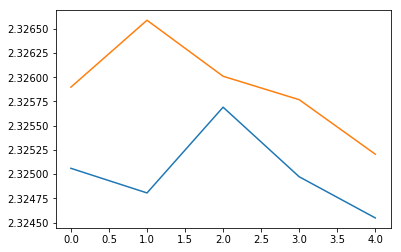

In [11]:
plt.plot(valid_loss)
plt.plot(train_loss)
plt.show()

### Accuracy

In [12]:
model.load_state_dict(torch.load('model_cifar.pt'))

In [13]:
# Test set accuracy
model.eval()
accuracy = 0
with torch.no_grad():
    epoch_loss = 0
    for ii,(images, labels) in enumerate(test_loader):
        output = model.forward(images)
        acc = labels.numpy()==np.argmax(output.numpy(), axis=1)
        acc = np.mean(acc)
        accuracy +=(acc.astype('float'))
        epoch_loss +=loss
print("Test accuracy of the system:",accuracy/ii)

Test accuracy of the system: 0.100200400802
